In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
market_open = pd.Timestamp("09:30:00").time()
market_close = pd.Timestamp("16:00:00").time()

In [ ]:
AAPL_data_path = "AAPL_data/AAPL_2024-10-21_xnas-itch.parquet"

df = pd.read_parquet(AAPL_data_path)
df = df.reset_index().set_index("ts_event")

df = df.between_time(market_open, market_close)

df.head()

,ts_recv,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-21 10:00:00.040091885-04:00,2024-10-21 10:00:00.040257465-04:00,10,2,38,C,B,0,235.16,100,130,...,4,1,235.07,235.28,155,100,3,1,AAPL,2024-10-21
2024-10-21 10:00:00.049417807-04:00,2024-10-21 10:00:00.049584207-04:00,10,2,38,A,A,0,235.19,5,130,...,4,1,235.07,235.28,155,100,3,1,AAPL,2024-10-21
2024-10-21 10:00:00.052332349-04:00,2024-10-21 10:00:00.052498723-04:00,10,2,38,A,B,0,235.16,20,130,...,4,1,235.07,235.28,155,100,3,1,AAPL,2024-10-21
2024-10-21 10:00:00.056165880-04:00,2024-10-21 10:00:00.056332392-04:00,10,2,38,A,B,0,235.16,100,130,...,4,1,235.07,235.28,155,100,3,1,AAPL,2024-10-21
2024-10-21 10:00:00.160813294-04:00,2024-10-21 10:00:00.160980560-04:00,10,2,38,C,A,3,235.22,5,128,...,4,1,235.07,235.28,155,100,3,1,AAPL,2024-10-21


In [216]:
def resample_mid_prices(df, sampling_rate):
    """
    Resample the mid_price values by the given sampling rate to get highest, lowest, open, close, and mean prices.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the mid_price and depth columns.
    sampling_rate (str): The sampling rate for resampling the data.
    
    Returns:
    pd.DataFrame: DataFrame containing the resampled mid_price values and max depth.
    """
    df_copy = df.copy()
    df_copy["mid_price"] = df_copy[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df_copy["mid_price"] = df_copy["mid_price"].combine_first(df_copy["ask_px_00"])
    df_copy["mid_price"] = df_copy["mid_price"].combine_first(df_copy["bid_px_00"])
    
    mid_prices_high = df_copy["mid_price"].resample(sampling_rate).max().ffill()
    mid_prices_low = df_copy["mid_price"].resample(sampling_rate).min().ffill()
    mid_prices_close = df_copy["mid_price"].resample(sampling_rate).last().ffill()
    mid_prices_open = df_copy["mid_price"].resample(sampling_rate).first().ffill()

    max_depths = df_copy["depth"].resample(sampling_rate).max().ffill()

    # Combine the resampled mid_price values into a single DataFrame
    mid_prices = pd.DataFrame({
        'mid_price_high': mid_prices_high,
        'mid_price_low': mid_prices_low,
        'mid_price_close': mid_prices_close,
        'mid_price_open': mid_prices_open,
        'max_depth': max_depths,
    })
    
    return mid_prices

In [218]:
def group_and_pivot_order_sizes(df, sampling_rate):
    """
    Group by ts_event, action, and side, then sum the sizes and pivot the table to create new columns for each combination of action and side.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the ts_event, action, side, and size columns.
    sampling_rate (str): The sampling rate for grouping the data.
    
    Returns:
    pd.DataFrame: DataFrame with pivoted columns for each combination of action and side.
    """
    # Group by ts_event, action, and side, then sum the sizes
    grouped = df.groupby([pd.Grouper(freq=sampling_rate), 'action', 'side'])['size'].sum().reset_index()

    # Pivot the table to create new columns for each combination of action and side
    order_sizes = grouped.pivot_table(index='ts_event', columns=['action', 'side'], values='size', fill_value=0)

    # Drop unnecessary columns
    columns_to_keep = [('A', 'A'), ('A', 'B'), ('C', 'A'), ('C', 'B'), ('T', 'A'), ('T', 'B')]
    order_sizes = order_sizes[columns_to_keep]

    # Define mappings for action and side
    action_mapping = {'A': 'add', 'C': 'cancel', 'T': 'trade'}
    side_mapping = {'A': 'ask', 'B': 'bid'}

    # Rename columns
    order_sizes.columns = [f'{action_mapping[action]}_{side_mapping[side]}_size' for action, side in order_sizes.columns]

    order_sizes["net_add_ask_size"] = order_sizes["add_ask_size"] - order_sizes["cancel_ask_size"]
    order_sizes["net_add_bid_size"] = order_sizes["add_bid_size"] - order_sizes["cancel_bid_size"]

    order_sizes.drop(columns=["add_ask_size", "add_bid_size", "cancel_ask_size", "cancel_bid_size"], inplace=True)

    return order_sizes


In [219]:
import ta  

def compute_technical_indicators(df):
    """
    Compute technical indicators for a given DataFrame with OHLC-like structure.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    df["Returns"] = df["mid_price_close"].pct_change()
    df["Target_close"] = np.sign(df["Returns"])
    
    ### TREND INDICATORS ###
    df['ADX_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=5).adx()
    df['ADX_7'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=7).adx()
    df['ADX_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=10).adx()
    df['DMP_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=5).adx_pos()
    df['DMP_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=10).adx_pos()
    df['DMN_5'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=5).adx_neg()
    df['DMN_10'] = ta.trend.ADXIndicator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=10).adx_neg()
    
    # Aroon Indicator requires both high and low prices
    df['AROONU_7'] = ta.trend.AroonIndicator(df['mid_price_high'], df['mid_price_low'], window=7).aroon_up()
    df['AROOND_7'] = ta.trend.AroonIndicator(df['mid_price_high'], df['mid_price_low'], window=7).aroon_down()
    
    # Open-Low and Open-High calculations
    df['OLL3'] = df['mid_price_open'] - df['mid_price_low'].rolling(window=3).min()
    df['OLL5'] = df['mid_price_open'] - df['mid_price_low'].rolling(window=5).min()
    df['OLL10'] = df['mid_price_open'] - df['mid_price_low'].rolling(window=10).min()
    df['OLL15'] = df['mid_price_open'] - df['mid_price_low'].rolling(window=15).min()
    df['OHH3'] = df['mid_price_high'].rolling(window=3).max() - df['mid_price_open']
    df['OHH5'] = df['mid_price_high'].rolling(window=5).max() - df['mid_price_open']
    
    ### OSCILLATORS ###
    df['STOCHk_14_3_3'] = ta.momentum.StochasticOscillator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=14, smooth_window=3).stoch()
    df['STOCHd_14_3_3'] = ta.momentum.StochasticOscillator(df['mid_price_high'], df['mid_price_low'], df['mid_price_close'], window=14, smooth_window=3).stoch_signal()

    # Avoid NaN Stochastic values
    df['STOCHk_14_3_3'] = df['STOCHk_14_3_3'].ffill()
    df['STOCHd_14_3_3'] = df['STOCHd_14_3_3'].ffill()

    df['MACD_8_21_5'] = ta.trend.MACD(df['mid_price_close'], window_slow=21, window_fast=8, window_sign=5).macd_diff()
    df['RSI_7'] = ta.momentum.RSIIndicator(df['mid_price_close'], window=7).rsi()
    df['AO_5_10'] = ta.momentum.AwesomeOscillatorIndicator(df['mid_price_high'], df['mid_price_low'], window1=5, window2=10).awesome_oscillator()

    ### MOVING AVERAGES ###
    df['EMA_15'] = ta.trend.EMAIndicator(df['mid_price_close'], window=15).ema_indicator()
    df['HMA_10'] = ta.trend.WMAIndicator(df['mid_price_close'], window=10).wma()  # HMA is not directly available in 'ta', using WMA as a placeholder
    df['KAMA_3_2_10'] = ta.momentum.KAMAIndicator(df['mid_price_close'], window=3, pow1=2, pow2=10).kama()
    df['MA_10'] = ta.trend.SMAIndicator(df['mid_price_close'], window=10).sma_indicator()
    df['MA_20'] = ta.trend.SMAIndicator(df['mid_price_close'], window=20).sma_indicator()
    
    # Rolling CO (Close - Open)
    for w in [3, 4, 5, 6]:
        df[f'rmCO({w})'] = (df['mid_price_close'] - df['mid_price_open']).rolling(window=w).mean()
    
    ### VOLATILITY INDICATORS ###
    df['Bollinger_Upper'] = ta.volatility.BollingerBands(df['mid_price_close'], window=20, window_dev=2).bollinger_hband()
    df['Bollinger_Lower'] = ta.volatility.BollingerBands(df['mid_price_close'], window=20, window_dev=2).bollinger_lband()
    df['U_minus_L'] = df['Bollinger_Upper'] - df['Bollinger_Lower']
    df['MA20dSTD'] = df['mid_price_close'].rolling(window=20).std()


    ### OTHER INDICATORS ###
    df['CO'] = df['mid_price_close'] - df['mid_price_open']
    df["C1O1"] = df["CO"].shift(1)
    df['C2O2'] = df["CO"].shift(2)
    df['C3O3'] = df["CO"].shift(3)
    df['range'] = df['mid_price_high'] - df['mid_price_low']
    df['OH1'] = df['mid_price_high'].shift(1) - df['mid_price_open'].shift(1)
    

    return df.dropna()

In [220]:
order_sizes = group_and_pivot_order_sizes(df, sampling_rate='2s')

mid_prices = resample_mid_prices(df, sampling_rate='2s')

mid_prices.iloc[:20]

,mid_price_high,mid_price_low,mid_price_close,mid_price_open,max_depth
ts_event,,,,,
2024-10-21 10:00:00-04:00,235.195,235.175,235.195,235.175,9
2024-10-21 10:00:02-04:00,235.290,235.195,235.290,235.195,9
2024-10-21 10:00:04-04:00,235.325,235.290,235.325,235.290,9
2024-10-21 10:00:06-04:00,235.345,235.315,235.320,235.325,9
2024-10-21 10:00:08-04:00,235.320,235.265,235.270,235.320,8
2024-10-21 10:00:10-04:00,235.330,235.270,235.315,235.270,9
2024-10-21 10:00:12-04:00,235.345,235.300,235.300,235.305,9
2024-10-21 10:00:14-04:00,235.305,235.260,235.270,235.300,9
2024-10-21 10:00:16-04:00,235.295,235.265,235.270,235.270,7


In [221]:
order_sizes = order_sizes.reindex(mid_prices.index, fill_value=0)

technical_indicators = compute_technical_indicators(mid_prices)
df_combined = order_sizes.join(technical_indicators, how='inner')

df_combined.columns

df_combined.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_close', 'mid_price_open', "max_depth", "Returns"], inplace=True)
df_combined.columns

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'Target_close', 'ADX_5', 'ADX_7', 'ADX_10', 'DMP_5',
       'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5',
       'OLL10', 'OLL15', 'OHH3', 'OHH5', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'MACD_8_21_5', 'RSI_7', 'AO_5_10', 'EMA_15', 'HMA_10', 'KAMA_3_2_10',
       'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)',
       'Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD', 'CO',
       'C1O1', 'C2O2', 'C3O3', 'range', 'OH1'],
      dtype='object')

In [ ]:
start_date = pd.to_datetime("2024-10-01")
end_date = pd.to_datetime("2024-10-01")
date_range = pd.bdate_range(start=start_date, end=end_date)
data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

trade_days_data = []

for path in data_paths:
    df = pd.read_parquet(path)
    df = df.reset_index().set_index("ts_event")

    df = df.between_time(market_open, market_close)
    
    order_sizes = group_and_pivot_order_sizes(df, sampling_rate='1s')
    

    mid_prices = resample_mid_prices(df, sampling_rate='1s')
    
    order_sizes = order_sizes.reindex(mid_prices.index, fill_value=0)

    technical_indicators = compute_technical_indicators(mid_prices)
    df_combined = order_sizes.join(technical_indicators, how='inner')

    # df_combined.drop(columns=["max_depth", "Returns"], inplace=True)
    df_combined.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_close', 'mid_price_open', "max_depth", "Returns"], inplace=True)

    trade_days_data.append(df_combined)

all_data = pd.concat(trade_days_data)

print(all_data.shape)

all_data.head()


(19776, 48)


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Target_close,ADX_5,...,Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-01 10:00:24-04:00,250.0,0.0,-327.0,-123.0,226.185,226.155,226.180,226.185,-1.0,41.764187,...,226.236861,226.033639,0.203222,0.052125,-0.005,-0.010,-0.045,0.140,0.030,0.005
2024-10-01 10:00:25-04:00,104.0,0.0,80.0,-687.0,226.180,226.115,226.125,226.180,-1.0,34.379261,...,226.229642,226.033858,0.195783,0.050217,-0.055,-0.005,-0.010,-0.045,0.065,0.000
2024-10-01 10:00:26-04:00,100.0,1101.0,427.0,131.0,226.175,226.125,226.155,226.125,1.0,28.471319,...,226.225721,226.034779,0.190942,0.048976,0.030,-0.055,-0.005,-0.010,0.050,0.000
2024-10-01 10:00:27-04:00,0.0,100.0,70.0,497.0,226.170,226.150,226.165,226.160,1.0,23.744966,...,226.227732,226.034768,0.192964,0.049494,0.005,0.030,-0.055,-0.005,0.020,0.050
2024-10-01 10:00:28-04:00,442.0,0.0,-29.0,-243.0,226.165,226.140,226.145,226.165,-1.0,22.203019,...,226.225079,226.034921,0.190158,0.048774,-0.020,0.005,0.030,-0.055,0.025,0.010


In [223]:
all_data["Target_close"] = all_data["Target_close"].shift(-1)
all_data.dropna(inplace=True)

In [224]:
all_data.head()

,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Target_close,ADX_5,...,Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-01 10:00:24-04:00,250.0,0.0,-327.0,-123.0,226.185,226.155,226.180,226.185,-1.0,41.764187,...,226.236861,226.033639,0.203222,0.052125,-0.005,-0.010,-0.045,0.140,0.030,0.005
2024-10-01 10:00:25-04:00,104.0,0.0,80.0,-687.0,226.180,226.115,226.125,226.180,1.0,34.379261,...,226.229642,226.033858,0.195783,0.050217,-0.055,-0.005,-0.010,-0.045,0.065,0.000
2024-10-01 10:00:26-04:00,100.0,1101.0,427.0,131.0,226.175,226.125,226.155,226.125,1.0,28.471319,...,226.225721,226.034779,0.190942,0.048976,0.030,-0.055,-0.005,-0.010,0.050,0.000
2024-10-01 10:00:27-04:00,0.0,100.0,70.0,497.0,226.170,226.150,226.165,226.160,-1.0,23.744966,...,226.227732,226.034768,0.192964,0.049494,0.005,0.030,-0.055,-0.005,0.020,0.050
2024-10-01 10:00:28-04:00,442.0,0.0,-29.0,-243.0,226.165,226.140,226.145,226.165,1.0,22.203019,...,226.225079,226.034921,0.190158,0.048774,-0.020,0.005,0.030,-0.055,0.025,0.010


In [225]:
all_data.Target_close.value_counts()

Target_close
-1.0    7555
 1.0    7545
 0.0    4675
Name: count, dtype: int64

Correlation Matrix:
                  trade_ask_size  trade_bid_size  net_add_ask_size  \
trade_ask_size          1.000000        0.222690          0.222090   
trade_bid_size          0.222690        1.000000         -0.143499   
net_add_ask_size        0.222090       -0.143499          1.000000   
net_add_bid_size       -0.071672        0.221659         -0.427489   
mid_price_high         -0.001038        0.008224         -0.013315   
mid_price_low          -0.011287       -0.004035         -0.016679   
mid_price_close        -0.009488        0.005641         -0.024769   
mid_price_open         -0.001094       -0.003532         -0.003968   
ADX_5                   0.046989        0.063839          0.015602   
ADX_7                   0.047958        0.061418          0.016742   
ADX_10                  0.050405        0.062131          0.017406   
DMP_5                  -0.075960        0.251834         -0.192654   
DMP_10                 -0.067904        0.202753         -0.143000   


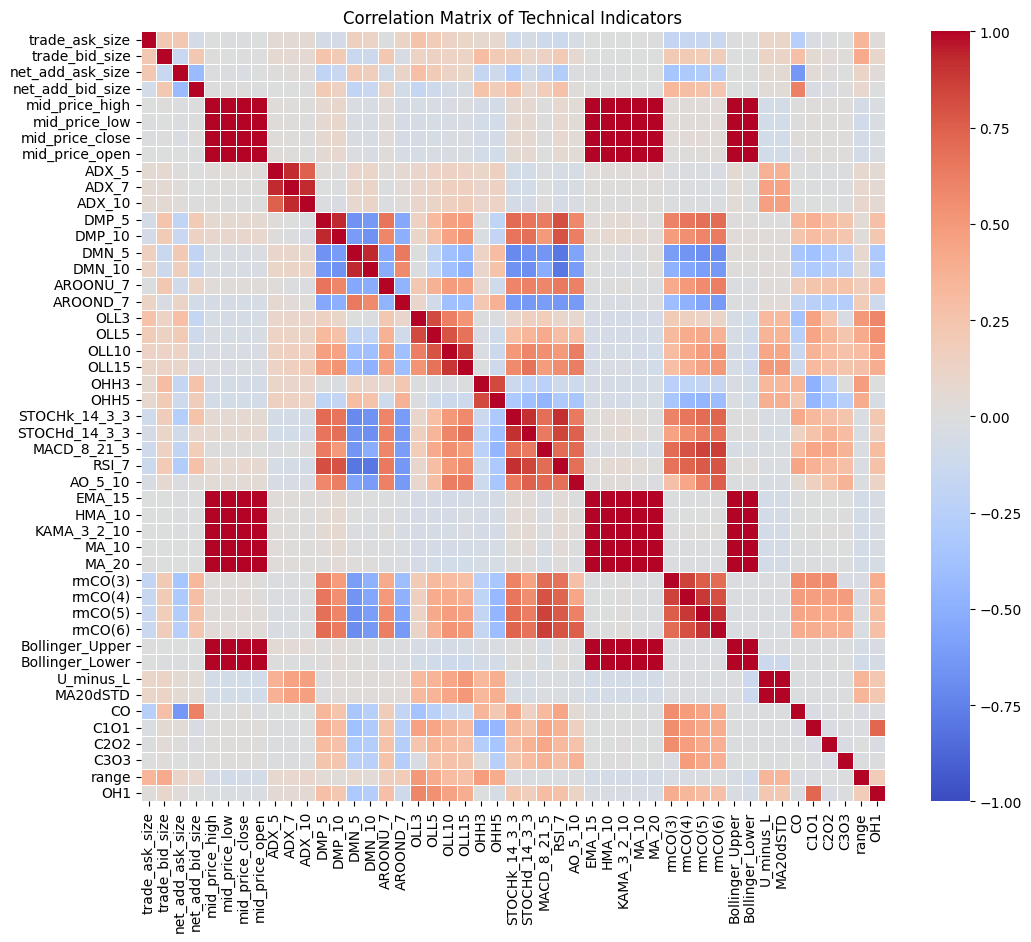

In [226]:
import seaborn as sns

correlation_matrix = all_data.drop(columns=["Target_close"]).corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

# Random Forest

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.032393
2   net_add_ask_size    0.032249
14            DMN_10    0.030341
25       MACD_8_21_5    0.030262
8              ADX_5    0.029781
13             DMN_5    0.029622
10            ADX_10    0.029551
11             DMP_5    0.029369
12            DMP_10    0.029317
39         U_minus_L    0.029227
40          MA20dSTD    0.029013
27           AO_5_10    0.028964
26             RSI_7    0.028136
24     STOCHd_14_3_3    0.028034
9              ADX_7    0.027919
23     STOCHk_14_3_3    0.023675
36           rmCO(6)    0.020960
38   Bollinger_Lower    0.020629
37   Bollinger_Upper    0.020137
35           rmCO(5)    0.019543


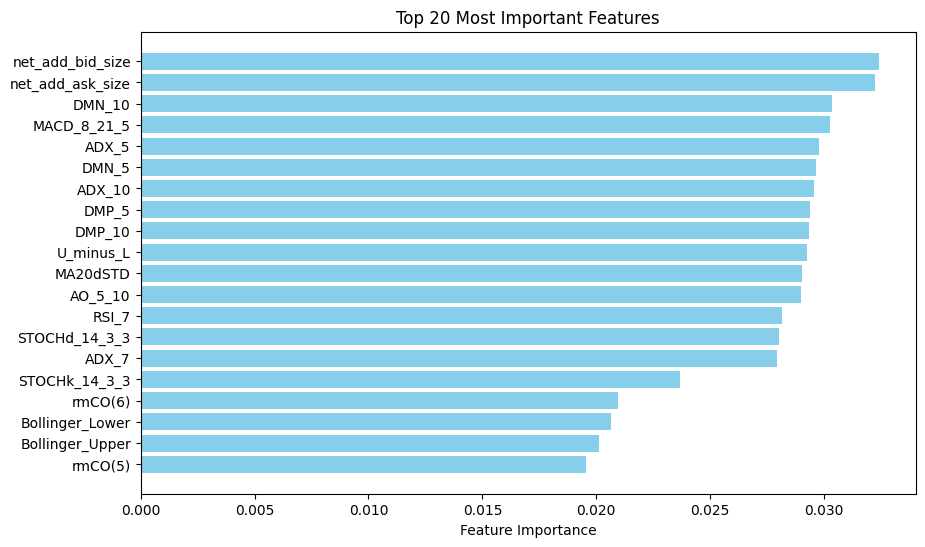

Top 20 Most Important Features:
             Feature  Importance
3   net_add_bid_size    0.032130
2   net_add_ask_size    0.031699
25       MACD_8_21_5    0.030291
14            DMN_10    0.030154
10            ADX_10    0.029638
8              ADX_5    0.029567
13             DMN_5    0.029486
11             DMP_5    0.029214
40          MA20dSTD    0.029188
12            DMP_10    0.029134
39         U_minus_L    0.029055
26             RSI_7    0.028679
9              ADX_7    0.028647
24     STOCHd_14_3_3    0.028208
27           AO_5_10    0.027273
23     STOCHk_14_3_3    0.023548
38   Bollinger_Lower    0.021278
36           rmCO(6)    0.020463
37   Bollinger_Upper    0.020312
32             MA_20    0.019864


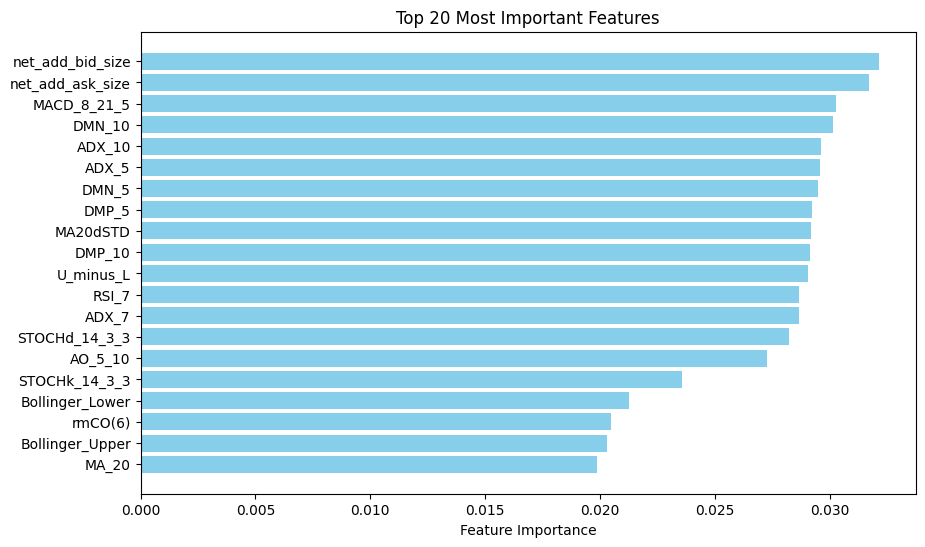

Top 20 Most Important Features:
             Feature  Importance
2   net_add_ask_size    0.034121
3   net_add_bid_size    0.033850
14            DMN_10    0.031679
13             DMN_5    0.031447
12            DMP_10    0.031446
25       MACD_8_21_5    0.031076
26             RSI_7    0.030768
8              ADX_5    0.030694
39         U_minus_L    0.030654
40          MA20dSTD    0.030594
10            ADX_10    0.030549
11             DMP_5    0.030359
9              ADX_7    0.029447
27           AO_5_10    0.029232
24     STOCHd_14_3_3    0.028989
23     STOCHk_14_3_3    0.025238
38   Bollinger_Lower    0.022108
37   Bollinger_Upper    0.021020
32             MA_20    0.019971
1     trade_bid_size    0.019592


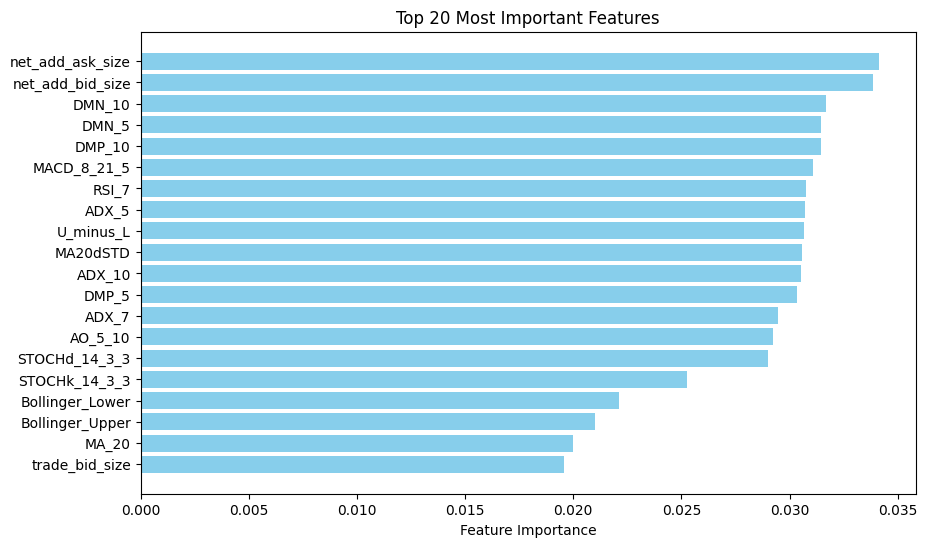

Top 20 Most Important Features:
             Feature  Importance
2   net_add_ask_size    0.037837
3   net_add_bid_size    0.037640
14            DMN_10    0.033149
25       MACD_8_21_5    0.032863
10            ADX_10    0.032736
13             DMN_5    0.032660
11             DMP_5    0.031973
8              ADX_5    0.031916
12            DMP_10    0.031737
39         U_minus_L    0.031174
9              ADX_7    0.030779
40          MA20dSTD    0.030705
27           AO_5_10    0.030551
24     STOCHd_14_3_3    0.030541
26             RSI_7    0.030119
23     STOCHk_14_3_3    0.024587
1     trade_bid_size    0.020931
36           rmCO(6)    0.020929
43              C2O2    0.020699
44              C3O3    0.020376


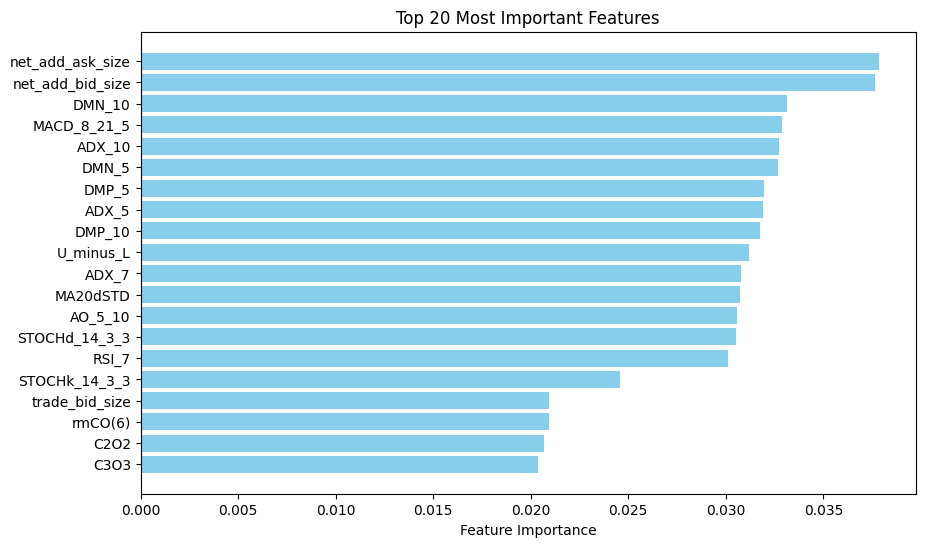

In [227]:
from sklearn.ensemble import RandomForestClassifier

X = all_data.drop(columns=['Target_close'])  # Features
y = all_data['Target_close']  # Target variable

params0 = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
params1 = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

params2={
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 5
}
params3={
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features' : 0.3
}

def analyze_feature_importance(X, y, num_features=20, **rf_params):
    """
    Analyze and visualize feature importance using a Random Forest model.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        **rf_params: Additional parameters to pass to RandomForestClassifier.

    Returns:
        importance_df (pd.DataFrame): DataFrame containing features and their importance scores.
    """
    # Initialize the Random Forest model
    rf = RandomForestClassifier(**rf_params)

    # Train the model on the entire dataset
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the top `num_features` most important features
    print(f"Top {num_features} Most Important Features:")
    print(importance_df.head(num_features))

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:num_features], importance_df['Importance'][:num_features], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_features} Most Important Features')
    plt.gca().invert_yaxis() 
    plt.show()

    return importance_df

importance_df0 = analyze_feature_importance(X, y, **params0)
importance_df1 = analyze_feature_importance(X, y, **params1)
importance_df2 = analyze_feature_importance(X, y, **params2)
importance_df3 = analyze_feature_importance(X, y, **params3)

Top 9 Most Important Features:
            Feature  Importance
0  net_add_ask_size    0.361702
1  net_add_bid_size    0.358732
3    trade_bid_size    0.146684
2    trade_ask_size    0.132882


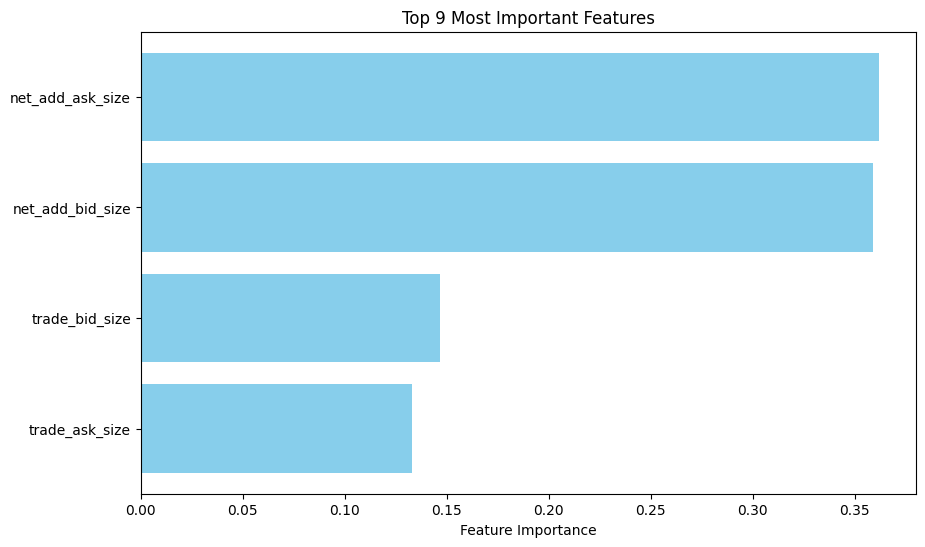

Top 9 Most Important Features:
            Feature  Importance
0  net_add_ask_size    0.364736
1  net_add_bid_size    0.357263
3    trade_bid_size    0.143868
2    trade_ask_size    0.134133


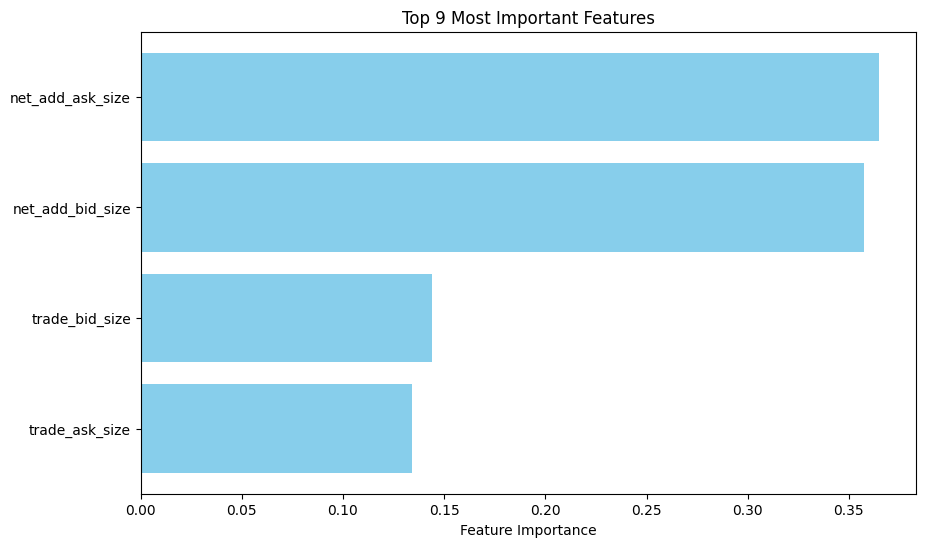

Top 9 Most Important Features:
            Feature  Importance
0  net_add_ask_size    0.348524
1  net_add_bid_size    0.345737
3    trade_bid_size    0.157253
2    trade_ask_size    0.148485


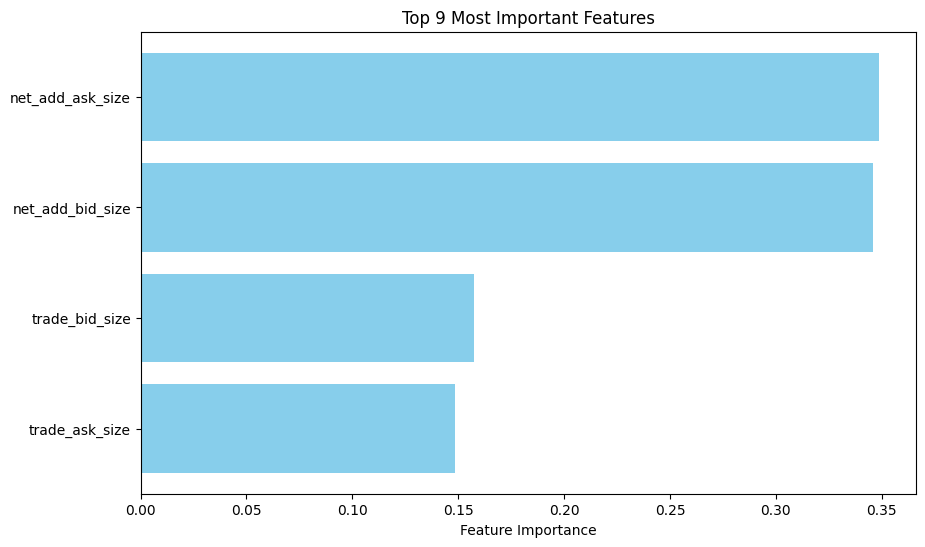

In [236]:
trend_indicators = ['ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5']
oscillators =[ 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10']
moving_averages = ['EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)']
volatility_indicators = ['Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD']
other_indicators = ['CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1']

price_indicators = ['mid_price_high', 'mid_price_low', 'mid_price_close', 'mid_price_open']
order_sizes_indicators = ['net_add_ask_size', 'net_add_bid_size', 'trade_ask_size', 'trade_bid_size']

importance_df_trend0 = analyze_feature_importance(X[order_sizes_indicators], y, num_features=9, **params0)
importance_df_trend1 = analyze_feature_importance(X[order_sizes_indicators], y, num_features=9, **params1)
importance_df_trend2 = analyze_feature_importance(X[order_sizes_indicators], y, num_features=9, **params2)

# PCA

In [229]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_selection(df, n_components=None, variance_threshold=0.95, num_features_to_keep=20):
    """
    Perform PCA-based feature selection and visualize the importance of the selected features.

    Parameters:
    - df: pandas DataFrame, the input dataset.
    - n_components: int or None, the number of principal components to keep. If None, it will be determined by the variance_threshold.
    - variance_threshold: float, the cumulative explained variance threshold to use if n_components is None.
    - num_features_to_keep: int, the number of top features to select.

    Returns:
    - features_to_keep: list, the names of the selected features.
    - sum_loadings: numpy array, the importance scores of the selected features.
    - selected_components_df: pandas DataFrame, the PCA components for the selected features.
    """
    # Step 1: Extract feature names and data
    features = df.columns.tolist() 
    X = df.values 

    # Step 2: Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA
    if n_components is None:
        # Compute all components to analyze explained variance
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Calculate cumulative explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Determine the number of components to retain based on the variance threshold
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold * 100}% of the variance.")
        
        # Re-fit PCA with the selected number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
    else:
        # Use the specified number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

    # Step 4: Get PCA components (loadings)
    components = pca.components_  # Each row is a principal component, each column is a feature
    components_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(len(components))])

    # Step 5: Calculate absolute factor loadings and sum them
    absolute_loadings = np.abs(components)  # Absolute values of loadings
    sum_loadings = np.sum(absolute_loadings, axis=0)  # Sum of loadings for each feature

    # Step 6: Sort features by importance
    sorted_indices = np.argsort(sum_loadings)[::-1]  # Indices of features sorted by importance

    # Step 7: Select top features
    features_to_keep = [features[i] for i in sorted_indices[:num_features_to_keep]]  # Top features

    # Step 8: Display results
    print("Top Features to Keep:", features_to_keep)
    print("\nImportance of Selected Features:")
    for feature in features_to_keep:
        index = features.index(feature)
        print(f"{feature}: Importance = {sum_loadings[index]:.4f}")

    # Step 9: Display PCA components for selected features
    selected_components_df = components_df[features_to_keep]
    print("\nPCA Components for Selected Features:")
    print(selected_components_df)

    # Step 10: Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features_to_keep), sum_loadings[sorted_indices[:num_features_to_keep]], align='center', color='skyblue')
    plt.xticks(range(num_features_to_keep), features_to_keep, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance (Sum of Absolute Loadings)')
    plt.title('Top Features by Importance')
    plt.tight_layout()
    plt.show()

    return features_to_keep, sum_loadings, selected_components_df

Selected 18 components to explain 95.0% of the variance.
Top Features to Keep: ['net_add_bid_size', 'trade_bid_size', 'trade_ask_size', 'net_add_ask_size', 'DMP_10', 'C3O3', 'AROONU_7', 'C2O2', 'DMN_10', 'AROOND_7', 'OH1', 'DMP_5', 'AO_5_10', 'OHH3', 'DMN_5', 'U_minus_L', 'MA20dSTD', 'STOCHk_14_3_3', 'C1O1', 'range']

Importance of Selected Features:
net_add_bid_size: Importance = 3.3271
trade_bid_size: Importance = 3.3156
trade_ask_size: Importance = 3.2146
net_add_ask_size: Importance = 2.9887
DMP_10: Importance = 2.4309
C3O3: Importance = 2.4275
AROONU_7: Importance = 2.4227
C2O2: Importance = 2.3623
DMN_10: Importance = 2.3041
AROOND_7: Importance = 2.1315
OH1: Importance = 2.1239
DMP_5: Importance = 2.0494
AO_5_10: Importance = 2.0218
OHH3: Importance = 2.0198
DMN_5: Importance = 1.9533
U_minus_L: Importance = 1.9474
MA20dSTD: Importance = 1.9474
STOCHk_14_3_3: Importance = 1.9344
C1O1: Importance = 1.9314
range: Importance = 1.8878

PCA Components for Selected Features:
      net

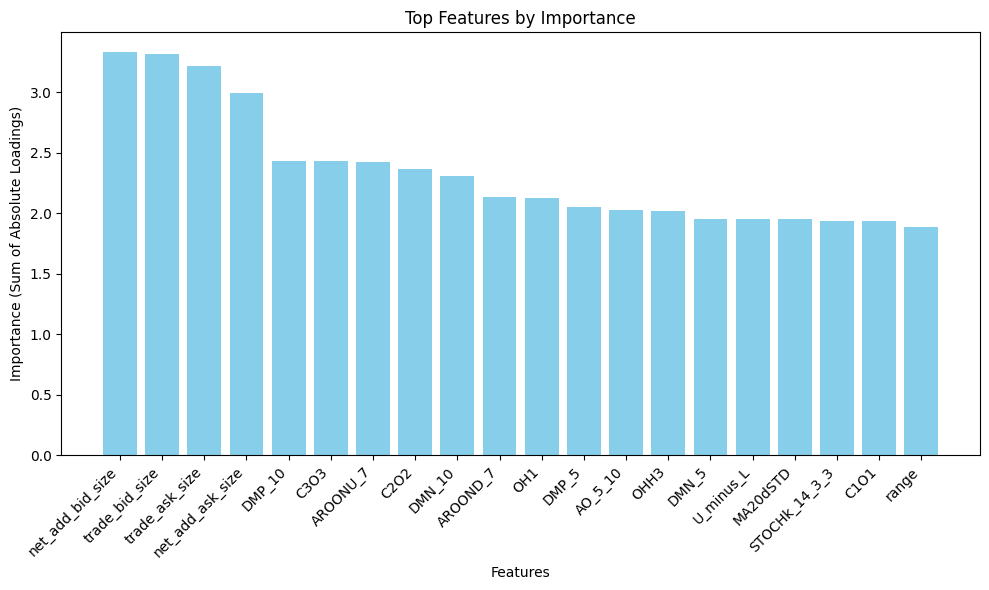

In [230]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data,  num_features_to_keep=20
)

Selected 8 components to explain 95.0% of the variance.
Top Features to Keep: ['AROONU_7', 'AROOND_7', 'OLL3', 'OLL15']

Importance of Selected Features:
AROONU_7: Importance = 2.2650
AROOND_7: Importance = 2.2522
OLL3: Importance = 1.9317
OLL15: Importance = 1.9226

PCA Components for Selected Features:
     AROONU_7  AROOND_7      OLL3     OLL15
PC1  0.316509 -0.285025  0.168213  0.339624
PC2 -0.014477  0.147936  0.244511  0.170851
PC3 -0.029240  0.241523  0.492420  0.184611
PC4  0.187248  0.086036 -0.096940 -0.011866
PC5  0.270649  0.310610  0.109908 -0.279266
PC6 -0.361509  0.608234  0.207213 -0.122010
PC7  0.690943  0.018749  0.204175 -0.369235
PC8  0.394378  0.554039 -0.408339  0.445103


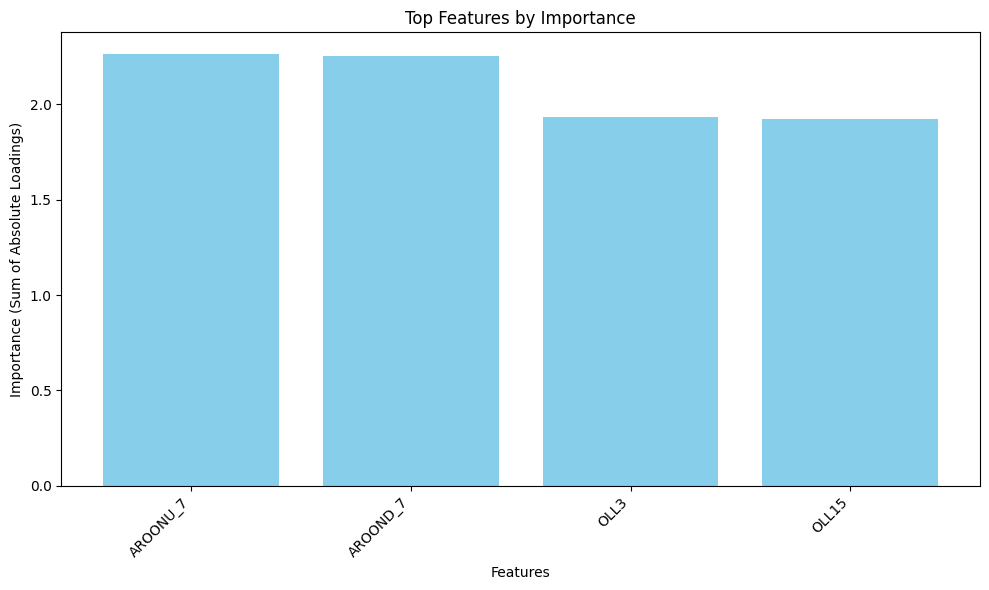

In [231]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data[trend_indicators],  num_features_to_keep=4
)